## Mixture Density Network

Mixture Density Networks (MDNs) [1] are mixture models in which the parameters such as means, covariances and mixture proportions are learned by a neural network. MDNs combine structured data representation (a density mixture) with unstructured parameter inference (MLP neural network). Mixture Density Network learn the mixture parameters by maximizing the log-likelihood or equivalently minimizing a negative log-likelihood loss.

Assuming a Gaussian Mixture Model (GMM) with $K$ components, we can write down the probability of a test data point $y_i$ conditioned on training data $x$ as follows:

\begin{equation}
    p(y_i|x) = \sum_{k=1}^{K}\pi_k(x) N\big(y_i| \mu_k(x), \Sigma_k(x)\big)
\end{equation}

where the parameters $\mu_k, \sigma_k, \pi_k$ are learned by a neural network (e.g. a Multi-Layer Perceptron (MLP)) parameterixed by $\theta$:

\begin{equation}
\mu_k, \sigma_k, \pi_k = \mathrm{NN}(x; \theta)
\end{equation}

As a result, the Neural Network (NN) is a multi-output model, subject to the following constraints on the ouput:

\begin{eqnarray}
    \forall k \sigma_{k}(x) &>& 0\\
    \sum_{k=1}^{K} \pi_k(x) &=& 1 
\end{eqnarray}

The first constraint can be achieved by using exponential activations, while the second constrained can be achieved by using softmax activations. Finally, by making use of the iid assumption, we want to minimize the following loss function:

\begin{eqnarray}
    \min_{\theta} L(\theta) &=& \mathrm{NLLLoss}(\theta) = - \log \prod_{i=1}^{n} p(y_i|x) = -\sum_{i=1}^{n} \log p(y_i|x) \\
    &=& - \sum_{i=1}^{n}\log \bigg[\sum_{k=1}^{K} \pi_k(x_i, \theta) N(y_i|\mu_k(x_i,\theta), \Sigma_{k}(x_i,\theta)) \bigg]
\end{eqnarray}

In the example below, we assume an isotropic covariance $\Sigma_k = \sigma_k^{2} I$, thus we can write a $d$-dimensional Gaussian as a product:

\begin{equation}
    N(y_i | \mu_k, \Sigma_k) = \frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}} \exp \bigg(-\frac{1}{2}(y_i-\mu_k)^{T}\Sigma_{k}^{-1}(y_i-\mu_k) \bigg)
\end{equation}

\begin{equation}
     N(y_i | \mu_k, \Sigma_k) = \frac{1}{(2\pi \sigma_{k}^{2})^{d/2}} \exp \bigg[-\frac{1}{2\sigma_{k}^{2}} \sum_{d=1}^{D}(y_{i,d} - \mu_{k,d})^2\bigg]
\end{equation}

\begin{equation}
    N(y_i | \mu_k, \Sigma_k) = \prod_{d=1}^{D} \frac{1}{\sigma_k \sqrt{2\pi}} \exp \bigg[-\frac{1}{2\sigma_{k}^{2}}(y_{i,d}-\mu_{k,d})^{2} \bigg]
\end{equation}

Let's implement a Gaussian MDN using Keras [3]!

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import math
import tensorflow as tf

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import concatenate, Input
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization

from keras.utils import np_utils
from keras.utils import plot_model
from keras.models import load_model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score 
from sklearn.model_selection import train_test_split

np.random.seed(0)
sns.set_style('whitegrid')

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


We'll use a synthetic dataset of K=4, 2-D Gaussians for ease of visualization.

In [3]:
def generate_data(N):
    pi = np.array([0.2, 0.4, 0.3, 0.1])
    mu = [[2,2], [-2,2], [-2,-2], [2,-2]]
    std = [[0.5,0.5], [1.0,1.0], [0.5,0.5], [1.0,1.0]]
    x = np.zeros((N,2), dtype=np.float32)
    y = np.zeros((N,2), dtype=np.float32)
    z = np.zeros((N,1), dtype=np.int32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n,:] = np.random.multivariate_normal(mu[k], np.diag(std[k]))
        y[n,:] = mu[k]
        z[n,:] = k
    #end for
    z = z.flatten()
    return x, y, z, pi, mu, std


Let's define a function for computing a D-dimensional Gaussian with isotropic covariance:

In [4]:
def tf_normal(y, mu, sigma):
    y_tile = K.stack([y]*num_clusters, axis=1) #[batch_size, K, D]
    result = y_tile - mu
    sigma_tile = K.stack([sigma]*data_dim, axis=-1) #[batch_size, K, D]
    result = result * 1.0/(sigma_tile+1e-8)
    result = -K.square(result)/2.0
    oneDivSqrtTwoPI = 1.0/math.sqrt(2*math.pi)    
    result = K.exp(result) * (1.0/(sigma_tile + 1e-8))*oneDivSqrtTwoPI
    result = K.prod(result, axis=-1)    #[batch_size, K] iid Gaussians
    return result


Finally, we'll define the negative log-likelihood loss which takes in a $d$-dimensional $y_{true}$ vector and MDN output parameters $y_{pred}$:

In [5]:
def NLLLoss(y_true, y_pred):
    out_mu = y_pred[:,:num_clusters*data_dim]
    out_sigma = y_pred[:,num_clusters*data_dim : num_clusters*(data_dim+1)] 
    out_pi = y_pred[:,num_clusters*(data_dim+1):]

    out_mu = K.reshape(out_mu, [-1, num_clusters, data_dim])

    result = tf_normal(y_true, out_mu, out_sigma)
    result = result * out_pi
    result = K.sum(result, axis=1, keepdims=True)
    result = -K.log(result + 1e-8)
    result = K.mean(result)
    return tf.maximum(result, 0)


Let's generate and visualize training and test data:

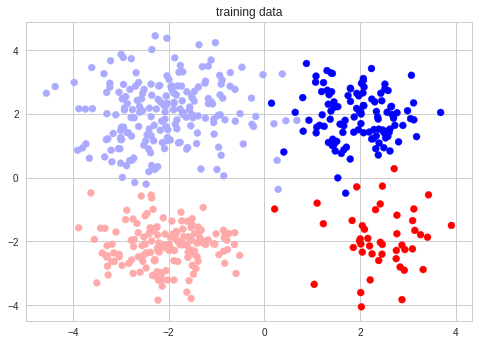

In [6]:
#generate data
X_data, y_data, z_data, pi_true, mu_true, sigma_true = generate_data(1024)

data_dim = X_data.shape[1]
num_clusters = len(mu_true)
#X_data, y_data = make_blobs(n_samples=1000, centers=num_clusters, n_features=data_dim, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=0, test_size=0.7)

num_train = 512 
X_train, X_test, y_train, y_test = X_data[:num_train,:], X_data[num_train:,:], y_data[:num_train,:], y_data[num_train:,:]
z_train, z_test = z_data[:num_train], z_data[num_train:]

#visualize data
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=z_train, cmap=cm.bwr)
plt.title('training data')
plt.savefig('./figures/mdn_training_data.png')


We can now define the training parameters as well as MDN parameters and architecture:

In [7]:
#training params
batch_size = 128 
num_epochs = 128 

#model parameters
hidden_size = 32
weight_decay = 1e-4

#MDN architecture
input_data = Input(shape=(data_dim,))
x = Dense(32, activation='relu')(input_data)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

mu = Dense(num_clusters * data_dim, activation='linear')(x) #cluster means
sigma = Dense(num_clusters, activation=K.exp)(x)            #diagonal cov
pi = Dense(num_clusters, activation='softmax')(x)           #mixture proportions
out = concatenate([mu, sigma, pi], axis=-1)

model = Model(input_data, out)
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=NLLLoss, optimizer=adam, metrics=['accuracy'])
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 32)            96          input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 32)            128         dropout_1[0][0]                  
___________________________________________________________________________________________

Let's train the model with early stopping:

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=32, verbose=1)
callbacks_list = [early_stopping]

#model training
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.2, shuffle=True, verbose=2)

Train on 409 samples, validate on 103 samples
Epoch 1/128
1s - loss: 5.9070 - acc: 0.0342 - val_loss: 6.0739 - val_acc: 0.0000e+00
Epoch 2/128
0s - loss: 5.5468 - acc: 0.0244 - val_loss: 5.9862 - val_acc: 0.0000e+00
Epoch 3/128
0s - loss: 5.5059 - acc: 0.0293 - val_loss: 5.8783 - val_acc: 0.0000e+00
Epoch 4/128
0s - loss: 5.2641 - acc: 0.0269 - val_loss: 5.7378 - val_acc: 0.0000e+00
Epoch 5/128
0s - loss: 5.0044 - acc: 0.0220 - val_loss: 5.5889 - val_acc: 0.0097
Epoch 6/128
0s - loss: 4.7956 - acc: 0.0196 - val_loss: 5.4150 - val_acc: 0.0194
Epoch 7/128
0s - loss: 4.7717 - acc: 0.0293 - val_loss: 5.2195 - val_acc: 0.0194
Epoch 8/128
0s - loss: 4.5822 - acc: 0.0293 - val_loss: 5.0472 - val_acc: 0.0291
Epoch 9/128
0s - loss: 4.4746 - acc: 0.0293 - val_loss: 4.9046 - val_acc: 0.0291
Epoch 10/128
0s - loss: 4.3982 - acc: 0.0513 - val_loss: 4.7775 - val_acc: 0.0388
Epoch 11/128
0s - loss: 4.3942 - acc: 0.0440 - val_loss: 4.6663 - val_acc: 0.0388
Epoch 12/128
0s - loss: 4.1395 - acc: 0.0611 

0s - loss: 1.1213 - acc: 0.0073 - val_loss: 0.1690 - val_acc: 0.0000e+00
Epoch 105/128
0s - loss: 1.2172 - acc: 0.0220 - val_loss: 0.1825 - val_acc: 0.0000e+00
Epoch 106/128
0s - loss: 0.9417 - acc: 0.0293 - val_loss: 0.2106 - val_acc: 0.0000e+00
Epoch 107/128
0s - loss: 1.1023 - acc: 0.0098 - val_loss: 0.2005 - val_acc: 0.0097
Epoch 108/128
0s - loss: 0.9184 - acc: 0.0269 - val_loss: 0.1490 - val_acc: 0.0097
Epoch 109/128
0s - loss: 0.9715 - acc: 0.0293 - val_loss: 0.0899 - val_acc: 0.0097
Epoch 110/128
0s - loss: 0.8439 - acc: 0.0220 - val_loss: 0.0525 - val_acc: 0.0097
Epoch 111/128
0s - loss: 0.7072 - acc: 0.0147 - val_loss: 0.0605 - val_acc: 0.0000e+00
Epoch 112/128
0s - loss: 0.6803 - acc: 0.0098 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 113/128
0s - loss: 0.7736 - acc: 0.0171 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 114/128
0s - loss: 0.5061 - acc: 0.0073 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 115/128
0s - loss: 0.7100 - acc: 0.0122 - val_loss: 0.0000e

We can now make predictions on test data:

In [9]:
print "predicting on test data..."
y_pred = model.predict(X_test)

mu_pred = y_pred[:,:num_clusters*data_dim]
mu_pred = np.reshape(mu_pred, [-1, num_clusters, data_dim])
sigma_pred = y_pred[:,num_clusters*data_dim : num_clusters*(data_dim+1)] 
pi_pred = y_pred[:,num_clusters*(data_dim+1):]
z_pred = np.argmax(pi_pred, axis=-1)

predicting on test data...


We'll evaluate clustering performance by computing the adjusted rand score, normalized mutual information and by comparing true and predicted values for means and standard deviations:

In [10]:
rand_score = adjusted_rand_score(z_test, z_pred)
print "adjusted rand score: ", rand_score 

nmi_score = normalized_mutual_info_score(z_test, z_pred)
print "normalized MI score: ", nmi_score 

adjusted rand score:  0.842059401234
normalized MI score:  0.840175516041


In [11]:
mu_pred_list = []
sigma_pred_list = []
for label in np.unique(z_pred):
    z_idx = np.where(z_pred == label)[0]
    mu_pred_lbl = np.mean(mu_pred[z_idx,label,:], axis=0)
    mu_pred_list.append(mu_pred_lbl)

    sigma_pred_lbl = np.mean(sigma_pred[z_idx,label], axis=0)
    sigma_pred_list.append(sigma_pred_lbl)
#end for

print "true means: "
print np.array(mu_true)

print "predicted means: "
print np.array(mu_pred_list)

print "true sigmas: "
print np.array(sigma_true)

print "predicted sigmas: "
print np.array(sigma_pred_list)

true means: 
[[ 2  2]
 [-2  2]
 [-2 -2]
 [ 2 -2]]
predicted means: 
[[ 2.13656688 -1.97987711]
 [-1.47537231 -2.03052163]
 [ 1.95446241  2.02965617]
 [-1.944049    1.96065593]]
true sigmas: 
[[ 0.5  0.5]
 [ 1.   1. ]
 [ 0.5  0.5]
 [ 1.   1. ]]
predicted sigmas: 
[ 1.26810288  0.30546659  0.61887544  0.15010625]


Notice the clustering scores are quite high, the predicted means are also close to the true means, however, the predicted sigmas are slightly off, possibly due to a difference between training and test data.

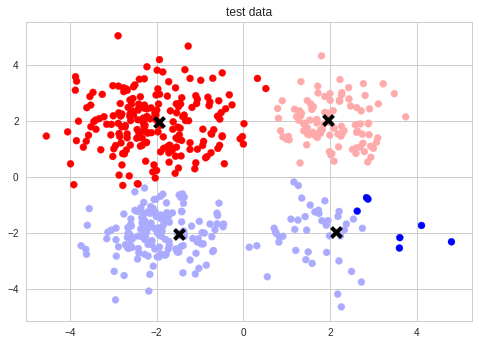

In [12]:
#generate plots
plt.figure()
plt.scatter(X_test[:,0], X_test[:,1], c=z_pred, cmap=cm.bwr)
plt.scatter(np.array(mu_pred_list)[:,0], np.array(mu_pred_list)[:,1], s=100, marker='x', lw=4.0, color='k')
plt.title('test data')
plt.savefig('./figures/mdn_test_data.png')


The black crosses in the figure above show the predicted means overlayed with test data. You can see visually, the means are close to cluster centers. 

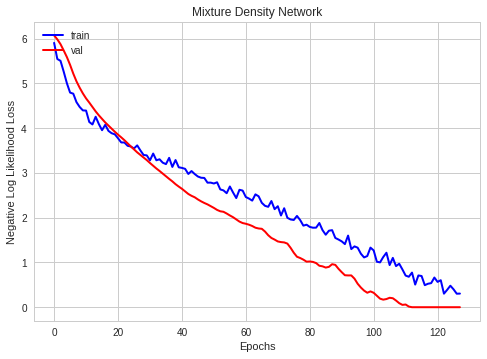

In [13]:
plt.figure()
plt.plot(hist.history['loss'], c='b', lw=2.0, label='train')
plt.plot(hist.history['val_loss'], c='r', lw=2.0, label='val')
plt.title('Mixture Density Network')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.legend(loc='upper left')
plt.savefig('./figures/mdn_loss.png')


We can see that both training and validation loss are decreasing with the number of epochs. 

### References

[1] C. Bishop, "Pattern Recognition and Machine Learning", 2006  
[2] EdwardLib, "Mixture Density Networks", http://edwardlib.org/tutorials/mixture-density-network  
[3] F. Chollet, "Keras: The Python Deep Learning library", https://keras.io/  
